## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import torch
from torch.optim import AdamW
import torch.optim as optim
import os
import warnings
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import logging
import matplotlib.pyplot as plt
from torch import cuda
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn import metrics
import numpy as np
import random
import gc

# Setup
device = 'cuda' if cuda.is_available() else 'cpu'
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")

# Print CUDA availability
print(torch.cuda.is_available())

True


In [2]:
!git lfs install
!git clone https://huggingface.co/bert-base-chinese

# 關閉 Hugging Face tokenizer 的多執行緒平行化警告，不影響結果或效能
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Git LFS initialized.
Cloning into 'bert-base-chinese'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 58 (delta 22), reused 51 (delta 19), pack-reused 0 (from 0)
Unpacking objects: 100% (58/58), 159.35 KiB | 5.90 MiB/s, done.
Filtering content: 100% (4/4), 1.59 GiB | 194.58 MiB/s, done.


## Set seeds

In [3]:
# 使資料打亂方式一樣
def set_seed(seed):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

set_seed(42)

## Parameter: you can modify

In [4]:
MAX_LEN = 256
WEIGHT_DECAY = 0.01
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 1
LEARNING_RATE = 2e-5
EPOCHS = 3

## Define model architecture

In [5]:
class ModelClass(torch.nn.Module):
    def __init__(self):
        super(ModelClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_path)
        self.dropout = torch.nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 256)
        self.activation = torch.nn.ReLU()                # ← 新增激活函數
        self.norm = torch.nn.LayerNorm(256)              # ← 新增 LayerNorm
        self.classifier = torch.nn.Linear(256, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]                       # [batch, seq_len, hidden]
        pooler = hidden_state[:, 0]                      # 取 [CLS] token 向量
        
        pooler = self.pre_classifier(pooler)
        pooler = self.activation(pooler)
        pooler = self.norm(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/kaggle/working/bert-base-chinese"

# 建立分類模型，num_labels=3 (replace/insert/delete)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=3
)

2025-10-01 08:47:26.726302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759308446.973952      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759308447.065356      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Dataset

In [7]:
#把原始 DataFrame（文字+標籤）轉換成適合 BERT/Transformer 模型訓練的 tensor 格式
# Create dataset class
class TrainData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.command
        self.targets = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets.iloc[index], dtype=torch.long)
        }

## Data Preprocessing

In [8]:
# Load data
trainPath = '/kaggle/input/hw-1-instruction-classifier/train.csv'
train_data = pd.read_csv(trainPath)

# 檢查 & 移除重複句子
train_data = train_data.drop_duplicates(subset=["command"]).reset_index(drop=True)

X = train_data["command"].values
y = train_data["label"].values

# 先切出 test set (30%)
# X為訓練資料，y為對應的label
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# StratifiedKFold切分
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in kf.split(X_temp, y_temp):
    X_tr, X_va = X_temp[train_idx], X_temp[valid_idx]
    y_tr, y_va = y_temp[train_idx], y_temp[valid_idx]

def check_overlap(set1, set2, name1="Set1", name2="Set2"):
    intersection = set(set1).intersection(set(set2))
    print(f"共有 {len(intersection)} 筆資料在{name1}和{name2}中重複")
    if len(intersection) > 0:
        print("部分重複範例：", list(intersection)[:5])

# 檢查 train/valid/test 是否重複
check_overlap(X_tr, X_va, "Train", "Valid")
check_overlap(X_tr, X_test, "Train", "Test")
check_overlap(X_va, X_test, "Valid", "Test")

# 初始化 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

共有 0 筆資料在Train和Valid中重複
共有 0 筆資料在Train和Test中重複
共有 0 筆資料在Valid和Test中重複


In [9]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_temp, y_temp)):
    if fold > 0:
        break
        
    X_tr, X_va = X_temp[train_idx], X_temp[valid_idx]
    y_tr, y_va = y_temp[train_idx], y_temp[valid_idx]

    # 計算類別權重
    cw = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    class_weights = torch.tensor(cw, dtype=torch.float).to(device)

    # 建立 Dataset 和 DataLoader
    train_set = TrainData(pd.DataFrame({'command': X_tr, 'label': y_tr}), tokenizer, MAX_LEN)
    valid_set = TrainData(pd.DataFrame({'command': X_va, 'label': y_va}), tokenizer, MAX_LEN)
    train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

    # 初始化模型、損失函數、優化器
    model = ModelClass().to(device)
    loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
    ### 優化器比較
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    # optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, alpha=0.99, weight_decay=WEIGHT_DECAY)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)



    # 模型會更新幾次參數
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    
    best_acc = 0

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            optimizer.zero_grad()
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            tt = batch['token_type_ids'].to(device)
            lbl = batch['targets'].to(device)

            output = model(ids, mask, tt)
            loss = loss_function(output, lbl)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            preds = output.argmax(dim=1)
            train_total += lbl.size(0)
            train_correct += (preds == lbl).sum().item()

        train_acc = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        

        # 驗證階段
        model.eval()
        valid_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in valid_loader:
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                tt = batch['token_type_ids'].to(device)
                lbl = batch['targets'].to(device)

                output = model(ids, mask, tt)
                loss = loss_function(output, lbl)
                valid_loss += loss.item()

                preds = output.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbl.cpu().numpy())


        valid_acc = 100 * ((np.array(all_preds) == np.array(all_labels)).mean())
        avg_valid_loss = valid_loss / len(valid_loader)

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)


        print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Epoch {epoch + 1} | Valid Loss: {avg_valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")

        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), f"best_fold{fold}.pt")
            print(f"Saved best model for fold {fold} at epoch {epoch + 1}")

    # 載入最佳模型並於測試集做評估
    model.load_state_dict(torch.load(f"best_fold{fold}.pt"))

    test_set = TrainData(pd.DataFrame({'command': X_test, 'label': y_test}), tokenizer, MAX_LEN)
    test_loader = DataLoader(test_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

    model.eval()
    test_correct = 0
    test_total = 0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for batch in test_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            tt = batch['token_type_ids'].to(device)
            lbl = batch['targets'].to(device)

            output = model(ids, mask, tt)
            preds = output.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(lbl.cpu().numpy())
            test_total += lbl.size(0)
            test_correct += (preds == lbl).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f"\nFold {fold + 1} Test Accuracy: {test_acc:.2f}%")
    print("Test Classification Report:")
    print(classification_report(test_labels, test_preds, digits=3, zero_division=0))
    print("Test Confusion Matrix:")
    print(confusion_matrix(test_labels, test_preds))


    # 釋放記憶體
    del model, optimizer, scheduler, train_loader, valid_loader, test_loader
    torch.cuda.empty_cache()
    import gc
    gc.collect()

    print(f"\nFold {fold + 1} completed")

Epoch 1 | Train Loss: 0.9841 | Train Acc: 52.12%
Epoch 1 | Valid Loss: 0.7816 | Valid Acc: 81.92%
Saved best model for fold 0 at epoch 1
Epoch 2 | Train Loss: 0.7399 | Train Acc: 74.76%
Epoch 2 | Valid Loss: 0.5407 | Valid Acc: 93.46%
Saved best model for fold 0 at epoch 2
Epoch 3 | Train Loss: 0.5824 | Train Acc: 85.36%
Epoch 3 | Valid Loss: 0.4693 | Valid Acc: 95.00%
Saved best model for fold 0 at epoch 3

Fold 1 Test Accuracy: 95.87%
Test Classification Report:
              precision    recall  f1-score   support

           0      0.943     0.971     0.957       206
           1      0.985     0.929     0.956       211
           2      0.945     0.986     0.965       140

    accuracy                          0.959       557
   macro avg      0.958     0.962     0.959       557
weighted avg      0.960     0.959     0.959       557

Test Confusion Matrix:
[[200   2   4]
 [ 11 196   4]
 [  1   1 138]]

Fold 1 completed


## Predict Test data

In [10]:
# 讀取無標籤測試資料
testPath = '/kaggle/input/hw-1-instruction-classifier/test_no_label.csv'
test_data = pd.read_csv(testPath)
print(f"Test data: {test_data.head(1)}")
print(f"Test Dataset shape: {test_data.shape}")

# 建立Test Dataset 和 DataLoader(不含 label)
class TestData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = dataframe['command']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

# 使用先前訓練好的模型對無標籤測試進行預測
test_set = TestData(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

# 假設用 fold 0 的最佳模型推論
model = ModelClass().to(device)
model.load_state_dict(torch.load("best_fold0.pt"))
model.eval()

test_set = TestData(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

all_test_preds = []
with torch.no_grad():
    for batch in test_loader:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        tt = batch['token_type_ids'].to(device)
        outputs = model(ids, mask, tt)
        preds = outputs.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())

print("Test prediction completed.")

Test data:    ID        command
0   0  更正出攝的攝字為出色的色字
Test Dataset shape: (14564, 2)
Test prediction completed.


In [11]:
# 預測函式
def predict_my(model, testing_loader):
    model.eval()
    output_list = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0), total=len(testing_loader)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            preds = torch.argmax(outputs, dim=1)
            output_list.extend(preds.cpu().tolist())

    return output_list

# 執行預測
output_list = predict_my(model, test_loader)
print("done")

# 將預測結果加入測試資料
test_data['label'] = output_list

# 產生成提交檔
submission = test_data[['ID', 'label']]
submission.to_csv("/kaggle/working/output.csv", index=False)

print(pd.read_csv("/kaggle/working/output.csv").head())


100%|██████████| 911/911 [03:40<00:00,  4.14it/s]

done
   ID  label
0   0      0
1   1      1
2   2      2
3   3      2
4   4      0


## Visualization of Model Training and Validation Performance

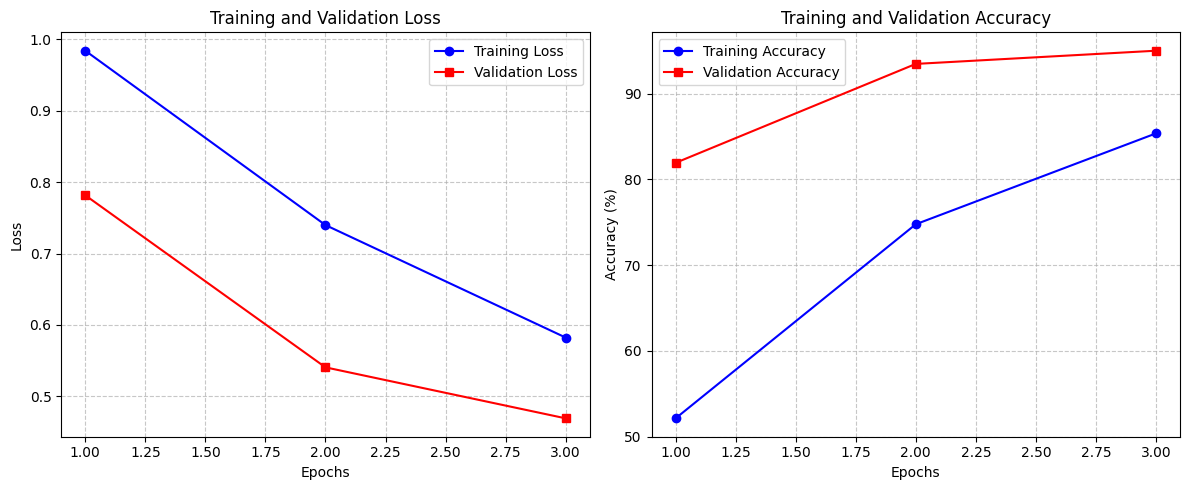

In [12]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, 'b-', marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), valid_losses, 'r-', marker='s', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accs, 'b-', marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), valid_accs, 'r-', marker='s', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

## Visualization of your validation data

In [13]:
def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)  # 或使用 class_weights
    
    
    with torch.no_grad():
        for batch in valid_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            tt = batch['token_type_ids'].to(device)
            lbl = batch['targets'].to(device)

            output = model(ids, mask, tt)
            loss = loss_function(output, lbl)
            valid_loss += loss.item()

            preds = output.argmax(dim=1)
            correct += (preds == lbl).sum().item()
            total += lbl.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbl.cpu().numpy())

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = 100 * correct / total

    # 計算 precision / recall / f1
    from sklearn.metrics import precision_score, recall_score, f1_score
    valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    valid_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return valid_acc, avg_valid_loss, valid_precision, valid_recall, valid_f1, all_preds, all_labels


In [14]:
valid_loader = DataLoader(valid_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
valid_acc, valid_loss, valid_precision, valid_recall, valid_f1, vaild_pred, vaild_target = valid(model, valid_loader)
# Generate classification report
report = classification_report(vaild_target, vaild_pred, digits=4)  # digits=4 controls the number of decimal places
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(vaild_target, vaild_pred)
print(conf_matrix)

              precision    recall  f1-score   support

           0     0.9474    0.9375    0.9424        96
           1     0.9787    0.9388    0.9583        98
           2     0.9155    0.9848    0.9489        66

    accuracy                         0.9500       260
   macro avg     0.9472    0.9537    0.9499       260
weighted avg     0.9511    0.9500    0.9501       260

[[90  2  4]
 [ 4 92  2]
 [ 1  0 65]]


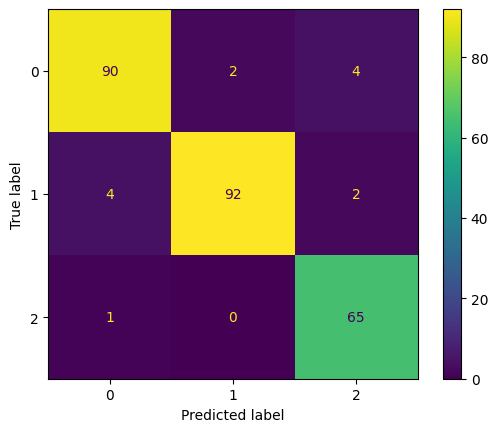

In [15]:
cm_display = metrics.ConfusionMatrixDisplay(
                confusion_matrix = conf_matrix, 
                display_labels = [0, 1, 2])
cm_display.plot()
plt.show()

## Store submission file

In [16]:
test_data['label'] = output_list

submission = test_data[['ID', 'label']]

submission.to_csv("/kaggle/working/output.csv", index=False)

print(pd.read_csv("/kaggle/working/output.csv").head())

   ID  label
0   0      0
1   1      1
2   2      2
3   3      2
4   4      0
